<a href="https://colab.research.google.com/github/yvesheri4/CMSE802/blob/main/Day20_InClass_ANN1_basic_model_YvesHERI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Day 20: In Class Assignment: Artificial neural network 1

### <p style='text-align: right;'> &#9989; Yves HERI.
#### <p style='text-align: right;'> &#9989; Yaman, Swayan, Stephe.


<img src= "https://storage.googleapis.com/kaggle-datasets-images/2243/3791/9384af51de8baa77f6320901f53bd26b/dataset-cover.png" width="80%">

The [Fashion MNIST dataset from Kaggle](https://www.kaggle.com/datasets/zalando-research/fashionmnist) we will be playing with today


## ___Learning objectives___

At the end of the exercise, you should be able to:
- Load existing Tensorflow dataset.
- Visualize image data as tensors.
- Build and train a simple ANN model.
- Understand loss and F1 and how they change over epochs.
- Change the model architure and understand its impacts.
- Evaluate an ANN model with test data.

---
## ___Outline___

1. [Review pre-class assignment](#preclass)
1. [Dataset and tensor](#dataset)
1. [Building an ANN classification model](#build)
1. [Train the model](#train)
1. [Impact of learning rate](#lr)
1. [Play with model architecture](#architecture)

----
<a id="preclass"></a>

## ___Pre-Class Assignment Review___

🗒️ **Question:** In the pre-class, you filled out the following table based on the example `model_basework` with the following archtecture:

- Two nodes in the input layer,
- Three nodes in the hidden layer,
- One node in the output layer.

And there are three instances. Discuss your results of the following table with your groupmates. Which part did you get wrong ad why?

|Variable|Definition|Dimension|
|---|---|---|
|$X$      |Feature value matrix|3x2|
|$W^{(1)}$|1st layer weight matrix|2x3|
|$z^{(2)}$|2nd layer activity|3x3|
|$f$      |Activation function|NA|
|$a^{(2)}$|2nd layer activity after activation|3x3|
|$W^{(2)}$|2nd layer weight matrix|3x1|
|$z^{(3)}$|3rd layer activity|3x1|
|$\hat{y}$|Output vector|3x1|


✏️ **Answer:**

We were able to get everything right in this part.

---
## ___Setup___

### _Important and key variables_

In [1]:
import numpy as np
import torchvision.datasets as datasets
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms
from tqdm import tqdm
from torcheval.metrics.functional import multiclass_f1_score
from helper_d22 import *

data_dir = './.data'

### _Reproducibility_

🗒️ **Task:** For pytorch, the way to improve reproducibility is to set `manual_seed`. Run the cell below to set it.

Let's use the same `rand_seed` this time so we can directly compare our results later.

In [2]:
rand_seed = 240320

torch.manual_seed(rand_seed)

---
<a id="dataset"></a>
## ___Dataset and tensor___

### _Dataset content_

We will use the [Fashion MINST](https://www.tensorflow.org/datasets/catalog/fashion_mnist) data set containing images of different kind of outfits. __Our goal here is to classify an image into one of 10 outfit class (e.g., Dress, Trouser, Shirt).__

🗒️ **Task:** Load the dataset and write code to:
1. Show the type of train and test sets,
1. Show the dimension of train and test sets.

In [3]:
### ANSWER
#
fashion_train_data = datasets.FashionMNIST(
    root=data_dir,
    train=True,
    download=True,
    transform=transforms.ToTensor()
    )

fashion_test_data  = datasets.FashionMNIST(
    root=data_dir,
    train=False,
    download=True,
    transform=None
    )

X_train_all = fashion_train_data.data
y_train_all = fashion_train_data.targets

X_test = fashion_test_data.data
y_test = fashion_test_data.targets

# put your code below

print(f'X_train type: {type(X_train_all)}')
print(f'X_train_all shape: {X_train_all.shape}')

print(f'y_train type: {type(y_train_all)}')
print(f'y_train_all shape: {y_train_all.shape}')

X_train type: <class 'torch.Tensor'>
X_train_all shape: torch.Size([60000, 28, 28])
y_train type: <class 'torch.Tensor'>
y_train_all shape: torch.Size([60000])


### _Tensor_

If your code above is correct, then you must have seen that the data type of `X_train` is `torch.Tensor`.

__Tensor__ is just another name for data arrays. So here we just encountered a new data type `torch.Tensor` that comes with the package pytorch, just like the `np.array` datatype that comes with the package numpy.

Similar to numpy, pytorch also defines a special set of commands that only apply to `torch.Tensor`. For example, the command for finding the minimal value of an np.array is `numpy.min`, but when you want to find the minimal value of an array stored as type `torch.tensor`, you should use `torch.min` instead.

🗒️ **Task:** Write code to:

- Print out the min and max values in `X_train_all`.
- Print out the unique values in `y_train_all` (use `torch.unique`).
- Print out the shape of the 1st instance in `X_train_all`.
- Create a variable called `class_names` with `fashion_train_data.classes` and print it out.

In [4]:
### ANSWER
print(f'Max value in X_train_all: {torch.max(X_train_all)}')
print(f'Min value in X_train_all: {torch.min(X_train_all)}')

print(torch.unique(y_train_all))

print(f'X_train_all first instance shape: {X_train_all[0].shape}')

class_names = fashion_train_data.classes

Max value in X_train_all: 255
Min value in X_train_all: 0
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
X_train_all first instance shape: torch.Size([28, 28])


### _Dataset and preprocessing_

In this dataset:
- There are 60,000 training images.
- There are 10,000 testing images.
- Each image is a 28x28 pixel image.
- Each pixel has a value from 0 to 255.
- Pixel values in these images are features.
- There are 10 classes with names from 0 to 9.

Since we are using laptop computer for this exercise and most do not have good GPU, we will use only a small subset of the data:

- 500 images of the training data for training,
- 500 images of the training data for validation,
- The testing data is untouched.
- We have 10 classes, so each class has exactly 50 images in training and validation.
- We need to normalize the data (the original feature values are from 0 to 255) to [0,1].

🗒️ **Task:**  Since the above are not a core learning objective, codes from doing all the above is wrapped into a helper function `get_subset`. Check out the docstring of this function to see what it is doing.

In [5]:
help(get_subsets)

Help on function get_subsets in module helper_d22:

get_subsets(data_dir, train_valid_size=200)
    Get training, validation, and test data
    Args:
      data_dir (str or Path): the directory to store the data
      train_valid_size (int): the number of images for training and validation
    Return:
      X_train (torch.Tensor): training images, defined by train_valid_size
      X_valid (torch.Tensor): validation images, defined by train_valid_size
      X_test (torch.Tensor): test images, all 6000 images per class
      y_train (torch.Tensor): training labels
      y_valid (torch.Tensor): validation labels
      y_test (torch.Tensor): test labels
      class_names (list): the names of the classes




🗒️ **Task:**  Run the following cell to use the helper function `get_subset` to:
- Transform the data,
- Get the transformed train, validation, and test dataset.

In [6]:
X_train, X_valid, X_test, y_train, y_valid, y_test, class_names = \
                                    get_subsets(data_dir, train_valid_size=50)

X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

(torch.Size([500, 28, 28]),
 torch.Size([500, 28, 28]),
 torch.Size([60000, 28, 28]),
 torch.Size([500]),
 torch.Size([500]),
 torch.Size([60000]))

🗒️ **Task:** Write code below to check the max and min values in training, validation, and test sets.

In [7]:
### ANSWER

print(f'Max value in X_train: {X_train.max()}')
print(f'Min value in X_train: {X_train.min()}')

print(f'Max value in X_valid: {X_valid.max()}')
print(f'Min value in X_valid: {X_valid.min()}')

print(f'Max value in X_test: {X_test.max()}')
print(f'Min value in X_test: {X_test.min()}')

Max value in X_train: 1.0
Min value in X_train: 0.0
Max value in X_valid: 1.0
Min value in X_valid: 0.0
Max value in X_test: 1.0
Min value in X_test: 0.0


---
<a id="build"></a>
## ___Building an ANN classification model___

### _Checking your hardware_

Training ANN is typically computationally extensive and usually requires a Graphical Processing Unit (GPU, graphics card). Most of your laptops however have weak GPUs that are not suitable for training.

🗒️ **Task:** Run the following cell to determine if GPU is available and, if not, use CPU.

In [8]:
print("gpu is available:", torch.cuda.is_available())

gpu is available: False


In [9]:
# I am using CPU here. But if you have gpu, try it.
device = torch.device("cpu")

print("Using device:", device)

Using device: cpu


### _Defining an nn.Module subclass_

We define our neural model_basework in Pytorch by
- subclassing `nn.Module`, and
- initializing the neural model_basework layers in __\_\_init\_\___.
- Every `nn.Module` subclass implements the operations on input data in the __forward__ method.

Let's create a base model with the following layers and activation function:
- __nn.Flatten__: The first, input layer with:
  - input: tensor of 3 dimensions
  - output: tensor of 2 dimensions with the last 2 flattened
- __nn.Linear__: the 2nd-4th layers, the first two are hidden layer and the last is the output layer.
  - Applies a linear transformation on the input using its stored weights and biases.
  - In its simplest form it takes two paramters:
  - `num_input_nodes`: The number of nodes in the previous layer,
  - `num_output_nodes`: The number of nodes in the current layer.
    - Let's have 500 (number of images in the training set), 100 (change this to whatever you want), and 10 (number of classes) output nodes for the 2nd, 3rd, and 4th layers, respectively.
- __nn.ReLU__: Rectified Linear Unit
  - Applied after linear transformations to introduce nonlinearity, helping neural model_baseworks learn a wide variety of phenomena.
  - In this model, we use `nn.ReLU` between our linear layers, but there are other activation function.
  - Below is a comparison of the output from sigmoid and ReLU.

<img src="https://miro.medium.com/v2/resize:fit:786/format:webp/1*XxxiA0jJvPrHEJHD4z893g.png" width=600 />

- __nn.Softmax__: generate a [`softmax`](https://en.wikipedia.org/wiki/Softmax_function) output
  - The last linear layer of the neural model_basework returns logits - raw values in [-infty, infty],
  - Logits are passed to the `nn.Softmax` module and scaled to values [0, 1] like probabilities that shows how likely the current image is in each of the classes.
  - The predicted label would then be the class with the highest probability.
  - For some historical reason, instead of just using the `softmax` function, we use the logrithm of it, which is essentially the same, as it does not change the ranking of the probabilities.

🗒️ **Task:** In the code cell below, fill in the missing parameters (??) and missing comments based on the above.

In [10]:
### ANSWER
#
# nn is torch.nn.
# F is torch.nn.functional.

class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(784,500) # Define the first fully connected layer
    self.fc2 = nn.Linear(500,100)  # Define the second fully connected layer
    self.out = nn.Linear(100,10)  # Define the output layer

  def forward(self,x):
    x = self.flatten(x)          # Has dimension 1x784
    x = F.relu(self.fc1(x))      # dimension 1x500
    x = F.relu(self.fc2(x))      # dimension 1x100
    x = F.relu(self.out(x))      # dimension 1x10
    x = F.log_softmax(x,dim=1)   # dimension 1x10

    return x

🗒️ **Task:** Run the following that:

- Constructs a baseline model object `model_base` from the `Classifer` class we just defined, so we have an actual, untrained model_basework!
- We call this "baseline" because we are not tuning any of the parameters and is just using it as is.
- Summarizes the structure of the model_basework you just created.

In [11]:
model_base = Classifier()

print(model_base)

Classifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (out): Linear(in_features=100, out_features=10, bias=True)
)


🗒️ **Task:**  Run the cell below to get the total number of  parameters (weights+bias).

In [12]:
total_num_param     = sum(p.numel() for p in model_base.parameters())
total_num_trainable = sum(p.numel() for p in model_base.parameters() if p.requires_grad)

print(total_num_param, total_num_trainable)

443610 443610


### _How well would an untrained model do?_

We have not trained the model yet and all the parameters are randomly initiated.

🗒️ **Task:** Comment on the following code and make sure you understand what each line is doing and run the code block to get how well an untrained model would do in classifying the images.


In [13]:
# Find the prediction using the training data
y_train_naive_pred = model_base(X_train)

# Prediction using the validation data
y_valid_naive_pred = model_base.forward(X_valid)

# Calculate the F1 score for the training data
train_naive_f1 = multiclass_f1_score(
      y_train_naive_pred.argmax(dim=1),  # comment
      y_train,                           # comment
      num_classes=len(class_names),      # comment
      average='macro'                    # comment
      )

# Calculate the F1 score for the validation data
valid_naive_f1 = multiclass_f1_score(
      y_valid_naive_pred.argmax(dim=1),
      y_valid,
      num_classes=len(class_names),
      average='macro'
      )

print("Naive train F1:", train_naive_f1.detach().numpy())
print("Naive valid F1:", valid_naive_f1.detach().numpy())



Naive train F1: 0.025732994
Naive valid F1: 0.02077814


🗒️ **Question:** What do those numbers mean? What would you expect those numbers to be if you were to guess randomly?

 __Hint:__ Look at the documentation, recall the definition of the F1 score.

✏️ **Answer:**

 F1 score is a machine learning evaluation metric that combines precision and recall scores. The F1 score ranges between 0 and 1, with 0 denoting the lowest possible result and 1 denoting a flawless result, meaning that the model accurately predicted each label.

---
<a id="train"></a>

## ___Train the model___

### _Required components_

Once a model is initiated, the next step is to train it with our taining data.

🗒️ **Task:** The following is an implemention of the `train` function.

__Study each line carefully and understand what it does.__


In [14]:
def train(model_base, X_train, y_train, X_valid, y_valid, epochs=100, lr=0.01, wd=0.0,
          model_name=""):
  '''Train the artificial neural model_basework
  Args:
    model_base (torch.nn.Module): the neural model_basework to be trained
    X_train (torch.Tensor): the input data for training
    y_train (torch.Tensor): the input labels for training
    X_valid (torch.Tensor): the input data for validation
    y_valid (torch.Tensor): the input labels for validation
    epochs (int): the number of epochs, default 100
    lr (float): the learning rate, default 0.01
    wd (float): the weight decay, default 0.0
    model_name (str): the name of the model to be saved, if empty, no save
  Returns:
    epoch_loss (list): the loss after each epoch
    epoch_f1 (list): the f1 score after each epoch
  '''
  ## IMPORTANT ##
  # pick a metric to measure the goodness of fit: negative log likelihood loss
  criterion = nn.NLLLoss()

  ## IMPORTANT ##
  # Pick a training algorithm that iteratively minimizes the loss
  # Here, we pick stochastic gradient descent from torch.optim
  optimizer = optim.SGD(model_base.parameters(), lr=lr, weight_decay=wd)

  # list to store the loss and f1 after each epoch
  epoch_loss = []
  epoch_f1 = []

  ## IMPORTANT ##
  # start training, update weights and bias.
  model_base.train()

  # go through the epochs
  for e in tqdm(range(epochs)):
    ## IMPORTANT ##
    # clear previously stored gradients if any
    optimizer.zero_grad()

    ## IMPORTANT ##
    # compute the output of the model_basework given the input data
    y_train_pred = model_base(X_train)
    y_valid_pred = model_base(X_valid)

    ## IMPORTANT ##
    # compute the difference between the predicted and true labels
    train_loss = criterion(y_train_pred, y_train)
    valid_loss = criterion(y_valid_pred, y_valid)

    # store the epoch and loss info
    epoch_loss.append([e, train_loss, valid_loss])

    # compute the multiclass f1 score for training and validation data
    train_f1 = multiclass_f1_score(y_train_pred.argmax(dim=1), y_train,
                                   num_classes=10, average='macro')
    valid_f1 = multiclass_f1_score(y_valid_pred.argmax(dim=1), y_valid,
                                   num_classes=10, average='macro')

    # store the epoch and f1 score
    epoch_f1.append([e, train_f1, valid_f1])

    ## IMPORTANT ##
    # compute the gradient of the loss function with respect to the parameters
    # based on the training loss **NOT** validation loss and stored the gradient
    # in `parameter.grad`
    train_loss.backward()

    ## IMPORTANT ##
    # update all the parameters stored in `parameter.grad`
    optimizer.step()

  # save the model
  if model_name != "":
    torch.save(model_base, model_name)

  return epoch_loss, epoch_f1

🗒️ **Question:** After examine the training function above:

- What is `nn.NLLLoss`? What is it used for?
- What is `optim.SGD`? What is it used for?
- Why do we need to do `optimizer.zero_grad()`?
- What is the line that define a forward pass thorugh the neural model_basework?
- What are the lines that define back propagataion?

✏️ **Answer:**

- Give the loss, define a criterion for evaluation of the training.
- Optimizer, the stochastic gradient descent, algorithm used for the optimisation
- to clear previously saved gradient

🗒️ **Task:** Write code to train the `model_base` model with 750 epochs, learning rate of 0.05, and weight decay (wd) of 0.0.

In [15]:
### ANSWER

epoch_loss_base, epoch_f1_base = train(model_base, X_train, y_train, X_valid, y_valid, epochs=750, lr=0.01, wd=0.0,
          model_name="")


100%|██████████| 750/750 [00:30<00:00, 24.67it/s]


### _Examine training and validation losses and F1s_

🗒️ **Task:** Run `plot_train_valid_score` to plot the training and validation losses and F1s over epochs.

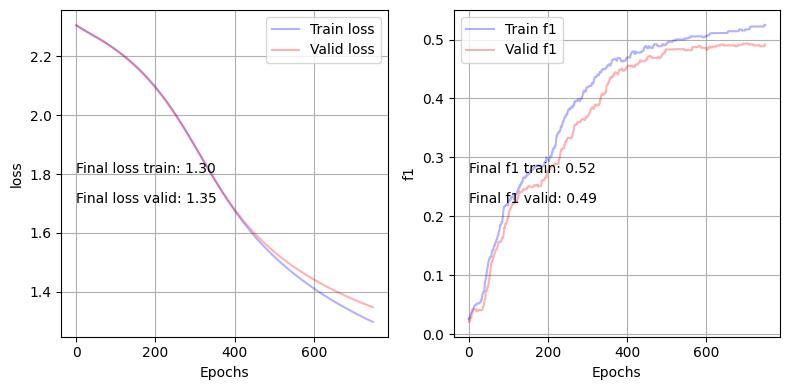

In [16]:
plot_train_valid_scores(epoch_loss_base, epoch_f1_base)

🗒️ **Question:** How do you interpret the plots above? Why do the red line sit above the blue one when plotting loss but below when plotting F1? do you think the number of iterations we set is enough for the training loss to reach its minimum?

✏️ **Answer:**

The training and validation losses decrease with the number of iterations, while the F1 score increases. We need certainly more iterations to reach the minimum loss.

### _Continue training_

The `model_base` model object contains updated weights and biases at the end of the training process. We can continue training it by call the train function again.

🗒️ **Task:** In the cell below, write code that will:

- Train the `model_base` model for another 1000 epochs, with all the same parameters,
- call the returned objects `epoch_loss_2`, and `epoch_f1_2`,
- Plot both losses and F1.


100%|██████████| 1000/1000 [00:33<00:00, 30.14it/s]


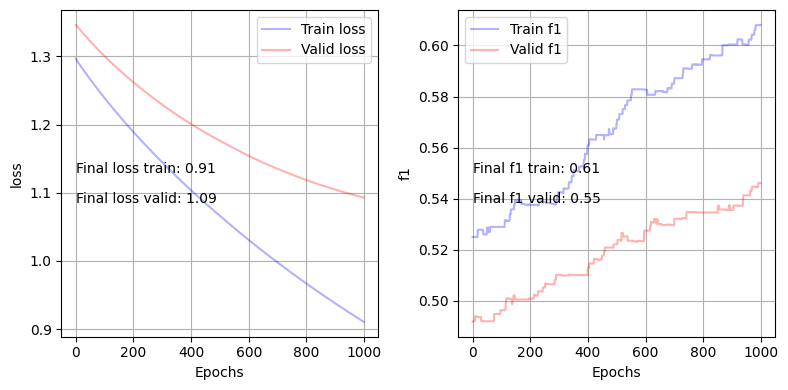

In [17]:
### ANSWER

epoch_loss_2, epoch_f1_2 = train(model_base, X_train, y_train, X_valid, y_valid, epochs=1000, lr=0.01, wd=0.0,
          model_name="")

plot_train_valid_scores(epoch_loss_2, epoch_f1_2)


🗒️ **Question:** What's your interpretation of the above results? Why does the loss and F1 fluctuate so much?

✏️ **Answer:**

If the learning rate is too high, the model may overshoot the optimal point, causing large fluctuations in the loss

---
<a id="lr"></a>

## ___Impact of learning rate___

As demonstrated earlier that there are quite a lot of fluctuation in loss and F1 over epochs. This is most likely due to poor learning rate choice.

🗒️ **Task:** To test this:

- Go to [this Excel sheet](https://michiganstate-my.sharepoint.com/:x:/g/personal/silves28_msu_edu/EX1nEc3cqeJLkCP-LqNBrmgBpPeQWHSH1OGW0VrAF1ye6w?e=zeYg1U&nav=MTVfezAwMDAwMDAwLTAwMDEtMDAwMC0wMDAwLTAwMDAwMDAwMDAwMH0), pick a learning rate you'd like to test and put your name next to it.
- Intialize a new `Classifier` object and call it `model_lr_test`,
- Use the same parameters as before to train `model_lr_test` except use the learning rate you have chosen and run for the chosen number of epochs.
- Plot the results,
- Share your loss and F1 results using the `Learning rate` tab of [the Excel sheet](https://michiganstate-my.sharepoint.com/:x:/g/personal/silves28_msu_edu/EX1nEc3cqeJLkCP-LqNBrmgBpPeQWHSH1OGW0VrAF1ye6w?e=zeYg1U&nav=MTVfezAwMDAwMDAwLTAwMDEtMDAwMC0wMDAwLTAwMDAwMDAwMDAwMH0), and copy and paste your plot in [this PowerPoint presentation slide](https://michiganstate-my.sharepoint.com/:p:/g/personal/silves28_msu_edu/Ef31CN7xzOZKlizcevhXE7EBjaISj-y_CAobxoYEDfNiRw?e=5luQow)

100%|██████████| 750/750 [00:24<00:00, 30.42it/s]


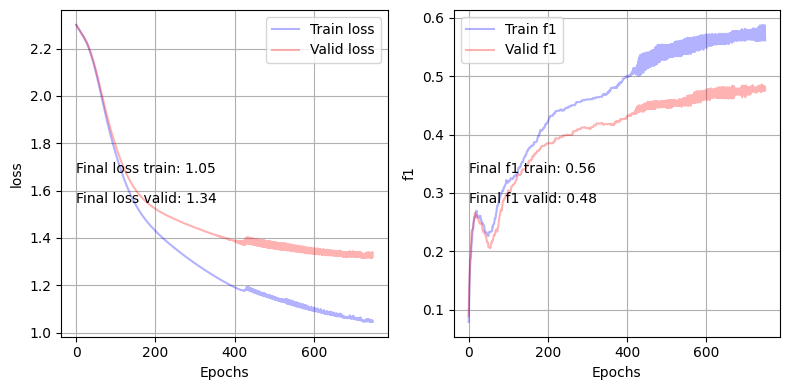

In [18]:
### ANSWER
model_lr_test = Classifier()
epoch_loss_lr, epoch_f1_lr = train(model_lr_test, X_train, y_train, X_valid, y_valid, epochs=750, lr=0.05, wd=0.0,
          model_name="")

plot_train_valid_scores(epoch_loss_lr, epoch_f1_lr)


🗒️ **Question:** What learning rate would you pick for this specific problem based on the results from your classmates?

✏️ **Answer:**

We can pick 0.01 as learning rate. For 1750 epoches.

---
<a id="architecture"></a>

## ___Play with model architecture___

The `Classifer` class specifies an architecture with:
- An flattened, input layer (`flatten`),
- A linear layer with 500 nodes (`fc1`),
- A linear layer with 500 nodes (`fc2`),
- A linear layer with 10 nodes (`out`),
- A softmax layer with 10 nodes (`softmax`).

🗒️ **Task:** In the following cell:

- Modify the `Classifer` class and call it `Classifer_mine`, create a new model architecture of your choice.
  - I.e., change the number of layers and nodes,
  - But leave `flatten`, `out`, and `softmax` unchanged,
  - Also leave the total number of nodes to be 1000.
- Create a new model with `Classifier_min` with a learning rate of 0.05 for 1750 epochs.
- Share your model architecture info, loss and F1 results in the `Model architecture` tab of [the Google sheet]((https://docs.google.com/spreadsheets/d/1f1H7ZedtMr02POAAMoZEDGYCHp4O2YpIzyHuyUmmEHs/edit#gid=1610218136)), and copy and past your plot in [this Google slide](https://docs.google.com/presentation/d/1Crh28_W-pEmHQM1pDH7bImWLH6y1w4u1OWtN8M5kOm8/edit#slide=id.g2c728e6d46c_0_0).

100%|██████████| 250/250 [00:09<00:00, 25.57it/s]


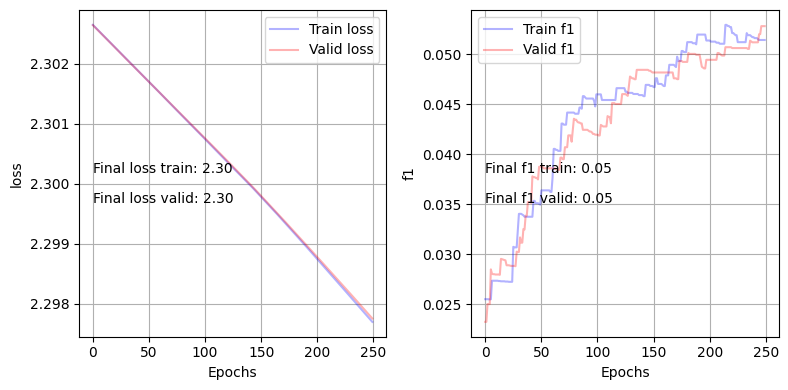

In [19]:
### ANSWER


class Classifier_mine(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(784,400) # Define the first fully connected layer
    self.fc2 = nn.Linear(400,300)  # Define the second fully connected layer
    self.fc3 = nn.Linear(300,200)  # Define the third fully connected layer
    self.fc4 = nn.Linear(200,100)  # Define the fourth fully connected layer
    self.out = nn.Linear(100,10)  # Define the output layer

  def forward(self,x):
    x = self.flatten(x)          # Has dimension 1x784
    x = F.relu(self.fc1(x))      # dimension 1x500
    x = F.relu(self.fc2(x))      # dimension 1x300
    x = F.relu(self.fc3(x))      # dimension 1x200
    x = F.relu(self.fc4(x))      # dimension 1x100
    x = F.relu(self.out(x))      # dimension 1x10
    x = F.log_softmax(x,dim=1)   # dimension 1x10

    return x

### ANSWER
model_lr_mine = Classifier_mine()
epoch_loss_mine, epoch_f1_mine = train(model_lr_mine, X_train, y_train, X_valid, y_valid, epochs=250, lr=0.01, wd=0.0,
          model_name="")

plot_train_valid_scores(epoch_loss_mine, epoch_f1_mine)

🗒️ **Question:** Take a look at the results posted by your classmates. Is there any general rule you may derived from how the model architecture should be defined?

✏️ **Answer:**

I use, an architecture with 4 hidden layers with 400, 300, 200, and 100 neurons respectively. This does not give good performances, but I choose to keep them as example of bad choice of architecture.

I could not access the Google sheet and the Google slide for comparison with classmates.

## Congratulations, you're done!

Submit this assignment by uploading your notebook to the course Desire2Learn web page.  Go to the "In-Class Assignments" folder, find the appropriate submission link, and upload everything there. Make sure your name is on it!

---

© 2024 Michigan State University. This material was created for the Department of Computational Mathematics, Science and Engineering (CMSE) at Michigan State University.